# Behavior Analysis: Duration Per Behavior Bout

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = 'project_ACC_MiniscopeSNI_3WeekMorphine'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['NoInjury','SNI']
selected_conditions = ['Combined']


### Main Code: Create Bar Graph of Duration Per Behavior Bout

/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/s

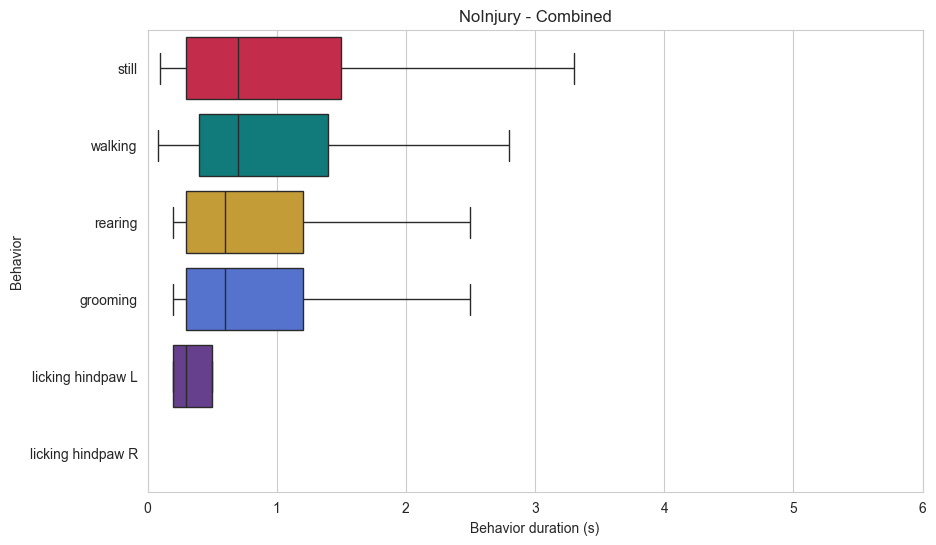

/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/s

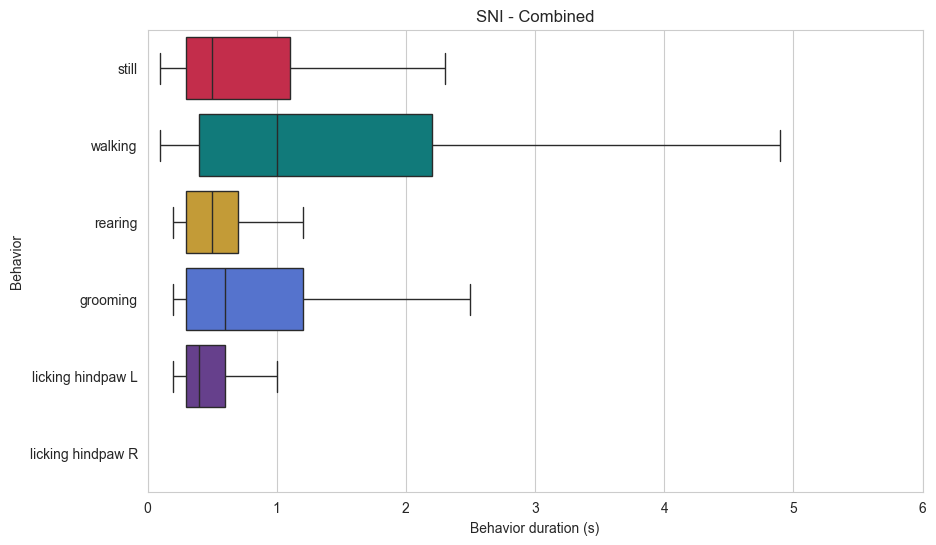

In [2]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import warnings

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

###### Load Behaviors ######
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_instance-durations"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def get_duration_bouts(predict, behavior_classes, framerate=60):
    behav_durations = []
    bout_start_idx = np.where(np.diff(np.hstack([-1, predict])) != 0)[0]
    bout_durations = np.hstack([np.diff(bout_start_idx), len(predict) - np.max(bout_start_idx)])
    bout_start_label = predict[bout_start_idx]
    for b, behavior_name in enumerate(behavior_classes):
        idx_b = np.where(bout_start_label == int(b))[0]
        if len(idx_b) > 0:
            behav_durations.append(bout_durations[idx_b] / framerate)
        else:
            a = np.empty((1,))
            a[:] = np.nan
            behav_durations.append(a)
    return behav_durations

# Iterate through groups and conditions
for selected_condition in selected_conditions:
    for selected_group in selected_groups:
        durations_ = []

        # Check if data exists for the selected group and condition
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            file_keys = list(behaviors[selected_group][selected_condition].keys())
            
            for file_name in file_keys:
                durations_.append(get_duration_bouts(behaviors[selected_group][selected_condition][file_name], behavior_names))
            
            # Create a DataFrame for the durations
            durations_dict = {
                'behavior': np.hstack([np.hstack([np.repeat(behavior_names[i], len(durations_[f][i])) 
                                                  for i in range(len(durations_[f]))]) 
                                       for f in range(len(durations_))]),
                'duration': np.hstack([np.hstack(durations_[f]) for f in range(len(durations_))]),
            }
            durations_df = pd.DataFrame(durations_dict)
            
            # Save the DataFrame
            csv_filename = f"../processed_dataset/{project_name}/figures/behavior_instance-durations/behavior_durations_{selected_group}_{selected_condition}.csv"
            durations_df.to_csv(csv_filename)

            # Create a boxplot for the durations
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.boxplot(
                data=durations_df, 
                x='duration', 
                y='behavior', 
                hue='behavior', 
                orient='h', 
                width=0.8,
                palette=behavior_colors, 
                showfliers=False, 
                ax=ax
            )
            
            # Customize the plot
            ax.set_title(f'{selected_group} - {selected_condition}')
            ax.set_xlabel('Behavior duration (s)')
            ax.set_ylabel('Behavior')
            ax.set_aspect('auto', adjustable='box')
            ax.set_xlim(0, 6)

            # Remove the legend for clarity
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

            # Save the plot
            fig.savefig(f"../processed_dataset/{project_name}/figures/behavior_instance-durations/behavior_durations_{project_name}_{selected_group}_{selected_condition}.svg",
                        dpi=600, bbox_inches='tight')
            plt.show()
        else:
            print(f"No data found for {selected_group} under condition {selected_condition}")

# ANALYSIS COMPLETE!

## Additional Analysis: Average Duration (seconds) of Behavioral Bouts Per File

In [3]:
import numpy as np
import pandas as pd

# This list will hold the durations for all files
all_file_durations = []

for row in range(len(selected_groups)):
    for col in range(len(selected_conditions)):
        selected_group = selected_groups[row]
        selected_condition = selected_conditions[col]

        # Check if the selected group and condition are available
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            file_keys = list(behaviors[selected_group][selected_condition].keys())
            
            for file_name in file_keys:
                # Get the duration bouts for the current file
                file_durations = get_duration_bouts(behaviors[selected_group][selected_condition][file_name], behavior_names)
                
                # Sum up all durations per behavior
                total_durations = [np.nansum(d) for d in file_durations]
                # Compute mean durations per behavior
                mean_durations = [np.nanmean(d) if not np.isnan(np.nanmean(d)) else 0 for d in file_durations]
                # Compute std durations per behavior
                std_durations = [np.nanstd(d) if not np.isnan(np.nanstd(d)) else 0 for d in file_durations]
                
                # Create a record with group, condition, filename, total/mean/std durations
                record = {
                    'group': selected_group,
                    'condition': selected_condition,
                    'file_name': file_name
                }
                
                # Add each behavior's total, average, and std duration to the record
                for i, behavior_name in enumerate(behavior_names):
                    record[f'{behavior_name}_total_duration_s'] = total_durations[i]
                    record[f'{behavior_name}_average_duration_s'] = mean_durations[i]
                    record[f'{behavior_name}_std_duration_s'] = std_durations[i]
                
                # Append the record to the list
                all_file_durations.append(record)

# Convert the list of records to a DataFrame
all_file_durations_df = pd.DataFrame(all_file_durations)

# Define the CSV file path and save the DataFrame
output_csv_path = f"../processed_dataset/{project_name}/figures/behavior_instance-durations/total_average_std_durations_per_file_{project_name}.csv"
all_file_durations_df.to_csv(output_csv_path, index=False)

print(f"Total, average, and std durations per file have been saved to {output_csv_path}")

Total, average, and std durations per file have been saved to ../processed_dataset/project_ACC_MiniscopeSNI_3WeekMorphine/figures/behavior_instance-durations/total_average_std_durations_per_file_project_ACC_MiniscopeSNI_3WeekMorphine.csv


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73233/1829037033.py:23: RuntimeWarning: Mean of empty slice
  mean_durations = [np.nanmean(d) if not np.isnan(np.nanmean(d)) else 0 for d in file_durations]
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
